# Running Strategy on Nasdaq and S&P500

# S&P500

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

import datetime as dt

import matplotlib.dates as mdates

In [2]:
def backtest_one_day(df, day_str, rank_to_expiry, initial_cash, sigma_target):
    day = pd.to_datetime(day_str).date()

    backtest_df = df[df['expiry_order'] == rank_to_expiry]
    backtest_df = (backtest_df.loc[(backtest_df['day'] == day)]
                               .sort_values('Time')
                               .copy())
    backtest_df = backtest_df.sort_values('hour')

    # --- basic guards ---
    if backtest_df.empty:
        return initial_cash

    # Pull scalars safely
    ret_std = backtest_df['ret_std_14d'].iloc[0]
    open_price = backtest_df['open_price'].iloc[0]

    # Validate inputs used in floor(); avoid NaN / inf / nonpositive std or price
    if (not np.isfinite(ret_std)) or (ret_std <= 0) or (not np.isfinite(open_price)) or (open_price <= 0):
        total_shares_to_hold = 0
    else:
        lev = 1  # cap leverage at 4x
        sizing = initial_cash * lev / open_price
        total_shares_to_hold = int(np.floor(sizing)) if np.isfinite(sizing) and sizing > 0 else 0

    # Extract arrays
    bid_list     = backtest_df['bid_px_00'].to_numpy()
    ask_list     = backtest_df['ask_px_00'].to_numpy()
    upper_bound  = backtest_df['upper_bound'].to_numpy()
    lower_bound  = backtest_df['lower_bound'].to_numpy()
    vwap_list    = backtest_df['vwap_cum'].to_numpy()
    hour         = backtest_df['hour'].to_numpy()
    price_list   = backtest_df['price'].to_numpy()

    # Length / NaN checks
    n = len(bid_list)
    if not (len(ask_list) == len(vwap_list) == len(hour) == len(upper_bound) == len(lower_bound) == len(price_list) == n) or n == 0:
        return initial_cash

    # IMPORTANT: your previous NaN check added arrays together (elementwise sum).
    # Do proper per-array NaN checks:
    if (np.isnan(bid_list).any() or np.isnan(ask_list).any() or
        np.isnan(vwap_list).any() or np.isnan(upper_bound).any() or
        np.isnan(lower_bound).any() or np.isnan(price_list).any()):
        return initial_cash

    position = 0
    cash = float(initial_cash)

    for i in range(1, len(price_list) - 1):
        if price_list[i] > max(upper_bound[i], vwap_list[i]):
            # we must be long and buy more than what we already have
            if total_shares_to_hold > position:
                shares_to_buy = total_shares_to_hold - position
                position += shares_to_buy
                initial_cash -= shares_to_buy * price_list[i] * 1.00001
                # print(f"Bought {shares_to_buy} shares at {ask_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] < min(vwap_list[i], lower_bound[i]):
            # we must be short and sell more than what we already have
            if -total_shares_to_hold < position:
                shares_to_sell = position + total_shares_to_hold
                position -= shares_to_sell
                initial_cash += shares_to_sell * price_list[i] * 0.99999
                # print(f"Sold {shares_to_sell} shares at {bid_list[i]} on {day_str} at {hour[i]}")

        elif price_list[i] >= min(vwap_list[i], lower_bound[i]) and max(upper_bound[i], vwap_list[i]) >= ask_list[i]:
            # we must close our position
            if position > 0: # we are long so we need to sell
                initial_cash += position * price_list[i] * 0.99999
                # print(f"Sold {position} shares at {bid_list[i]} on {day_str} at {hour[i]}")
                position = 0
            elif position < 0: # we are short so we need to buy
                initial_cash -= abs(position) * price_list[i] * 1.00001
                # print(f"Bought {abs(position)} shares at {ask_list[i]} on {day_str} at {hour[i]}")
                position = 0

    # closing daily position at last time point
    if position > 0: # we are long so we need to sell
        initial_cash += position * price_list[-1] * 0.99999
        position = 0

    elif position < 0: # we are short so we need to buy
        initial_cash -= abs(position) * price_list[-1] * 1.00001
        position = 0

    return initial_cash

# backtest_one_day(df, "2011-10-10", 1, 100000)

In [3]:
def backtest(backtest_df, rank_to_expiry, sigma_target, initial_cash=100_000):
    df1 = backtest_df.copy()

    # Ensure Time is datetime and non-null
    df1['Time'] = pd.to_datetime(df1['Time'], errors='coerce')
    df1 = df1.dropna(subset=['Time'])

    # Unique trading days (normalized to midnight) in ascending order
    unique_days = (
        df1['Time'].dt.normalize()
          .drop_duplicates()
          .sort_values()
          .to_list()
    )

    results = []
    cash = initial_cash

    for day_ts in unique_days:
        start_cash = cash
        # print(f"Running backtest for {day_ts.date()}")

        # keep your existing signature for backtest_one_day
        cash = backtest_one_day(df1, day_ts, rank_to_expiry, start_cash, sigma_target)
        # print(f"Cash after {day_ts.date()}: {cash}\n")

        pnl = cash - start_cash
        results.append({
            "date": day_ts,  # normalized pandas Timestamp
            "start_cash": start_cash,
            "end_cash": cash,
            "pnl": pnl,
            "return": (pnl / start_cash) if start_cash else np.nan,
            "traded": (pnl != 0),
        })

    return (pd.DataFrame(results)
              .sort_values("date")
              .reset_index(drop=True))

# backtest(df, rank_to_expiry = 1, sigma_target=0.02, initial_cash=100_000)

In [4]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/final_us_data.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return results


In [5]:
results_SP = backtest_with_hyperparameters(0.1, 0.005, 10, 14, 0.1)
results_SP

,date,start_cash,end_cash,pnl,return,traded
0,2010-06-07 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
1,2010-06-08 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
2,2010-06-09 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
3,2010-06-10 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
4,2010-06-11 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
...,...,...,...,...,...,...
3738,2024-12-24 00:00:00-05:00,205070.078476,205705.547431,635.468955,0.003099,True
3739,2024-12-26 00:00:00-05:00,205705.547431,205705.547431,0.000000,0.000000,False
3740,2024-12-27 00:00:00-05:00,205705.547431,204274.634844,-1430.912588,-0.006956,True
3741,2024-12-30 00:00:00-05:00,204274.634844,204274.634844,0.000000,0.000000,False


In [6]:
def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    # Basic checks and ordering
    needed = {'date','start_cash','end_cash','pnl','return','traded'}
    missing = needed.difference(perf.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = perf.copy().sort_values('date').reset_index(drop=True)

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # Daily returns (drop NaNs/infs quietly)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Geometric mean daily return (IRR over observed daily returns)
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_daily = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_daily) ** 252 - 1.0
    else:
        irr_daily = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_daily = float(daily_returns.std(ddof=1))
        vol_annual = vol_daily * np.sqrt(252.0)
    else:
        vol_daily = np.nan
        vol_annual = np.nan

    # Sharpe (annualized), using annual rf converted to daily
    rf_daily = (1.0 + float(risk_free_rate)) ** (1.0 / 252.0) - 1.0
    if n_obs > 1 and pd.notna(vol_daily) and vol_daily > 0:
        sharpe = ((daily_returns.mean() - rf_daily) / vol_daily) * np.sqrt(252.0)
    else:
        sharpe = np.nan

    # Hit ratio among traded days (your 'traded' flag)
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on the equity curve (end_cash)
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min())  # negative number (e.g., -0.18 for -18%)

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
    }

In [7]:
evaluate_strategy(results_SP)

{'total_return': 1.0351007403874357,
 'irr_annual': 0.04900064375833679,
 'vol_annual': 0.057489997461675435,
 'sharpe': 0.8608211966335058,
 'hit_ratio': 0.43469101123595505,
 'mdd': -0.09386661993782544,
 'n_days': 3743,
 'n_traded_days': 1424}

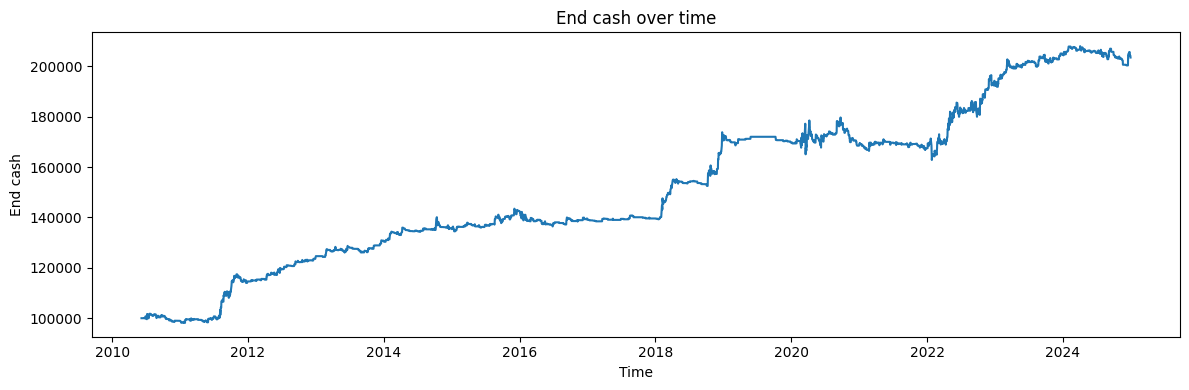

In [8]:
s = results_SP.copy()

# sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
# sp_df['SP500'] = 189095.59434874536 * sp_df['SP500'] / 1938.76
# sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

# if "observation_date" in sp_df.columns:
#     sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
#     sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
# plt.plot(sp_df['SP500'].astype(float))
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()

# NASDAQ

In [9]:
def backtest_with_hyperparameters(coef_sigma, percentage_penalization, sigma_leverage_period, sigma_leverage_bound, sigma_target):

    df = pd.read_csv('/data/workspace_files/nasdaq.csv')
    df = df[['Time', 'symbol', 'expiry_order', 'bid_px_00', 'ask_px_00', 'vwap_cum']]

    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=True)

    # (Optional) drop bad rows
    df = df.dropna(subset=['Time'])

    # Convert UTC -> New York (handles DST)
    df['Time'] = df['Time'].dt.tz_convert('America/New_York')

    # Build hour/day AFTER conversion
    df['hour'] = df['Time'].dt.strftime('%H:%M')
    df['day']  = df['Time'].dt.date

    # Keep only US RTH 09:30–16:00 ET
    market_open, market_close = dt.time(9, 30), dt.time(16, 0)
    df = df[df['Time'].dt.time.between(market_open, market_close)]

    # Sanity check (optional)
    tmin, tmax = df['Time'].dt.time.min(), df['Time'].dt.time.max()

    ### order by symbol, hour and day
    df = df.sort_values(['symbol', 'hour', 'day'])

    ### price
    df['price'] = 0.5 * (df['bid_px_00'] + df['ask_px_00'])


    ### opening price
    df['open_price'] = df.groupby(['symbol', 'day'])['price'].transform('first')


    # settling price and previous day settling price
    daily_settle = (
        df.sort_values(['symbol','day','Time'])
        .groupby(['symbol','day'])['price']
        .last()
        .rename('settl_price')
    )

    prev_settle = (
        daily_settle.groupby(level='symbol')
                    .shift(1)
                    .rename('settl_price_previous')
    )

    df = df.join(daily_settle, on=['symbol','day'])
    df = df.join(prev_settle,   on=['symbol','day'])


    ### move since opening
    df["move"] = np.where(
        df["open_price"] > 0,
        np.abs(df["price"] / df["open_price"] - 1),
        np.nan
    )


    ### compute mean of move over the last period
    df['sigma_observed'] = (
        df.groupby(['symbol', 'hour'])['move']
        .transform(lambda x: x.rolling(sigma_leverage_bound, min_periods=sigma_leverage_bound).mean())
    )


    ### compute upper bound
    df['upper_bound'] = (df[['open_price', 'settl_price_previous']].max(axis=1)) * (1 + coef_sigma * df['sigma_observed']) + percentage_penalization * df['open_price']


    ### compute lower bound
    df['lower_bound'] = (df[['open_price', 'settl_price_previous']].min(axis=1)) * (1 - coef_sigma * df['sigma_observed']) - percentage_penalization * df['open_price']


    ### get return
    df['return'] = df['settl_price']/df['open_price'] - 1


    ### get variance onf returns among the last 14 days
    daily = (df.sort_values(['symbol','day'])
            .groupby(['symbol','day'], as_index=False)['return'].last())

    daily[f'ret_std_14d'] = (
        daily.groupby('symbol')['return']
            .transform(lambda s: s.rolling(sigma_leverage_period, min_periods=sigma_leverage_period).std())
    )

    df = df.merge(daily[['symbol','day', f'ret_std_14d']], on=['symbol','day'], how='left')


    df = df.sort_values(['symbol', 'day', 'hour'])

    results = backtest(df, 1, sigma_target)

    return results


In [10]:
results_NASDAQ = backtest_with_hyperparameters(0.5, 0.002, 14, 14, 0.2)
results_NASDAQ

,date,start_cash,end_cash,pnl,return,traded
0,2010-06-07 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
1,2010-06-08 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
2,2010-06-09 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
3,2010-06-10 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
4,2010-06-11 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
...,...,...,...,...,...,...
3738,2024-12-24 00:00:00-05:00,375872.516755,378089.918236,2217.401481,0.005899,True
3739,2024-12-26 00:00:00-05:00,378089.918236,378089.918236,0.000000,0.000000,False
3740,2024-12-27 00:00:00-05:00,378089.918236,379093.073425,1003.155189,0.002653,True
3741,2024-12-30 00:00:00-05:00,379093.073425,378720.321267,-372.752158,-0.000983,True


In [11]:
evaluate_strategy(results_NASDAQ)

{'total_return': 2.77592755573733,
 'irr_annual': 0.09357483221743235,
 'vol_annual': 0.08155040941442078,
 'sharpe': 1.1376730719827486,
 'hit_ratio': 0.4264705882352941,
 'mdd': -0.1516056300345067,
 'n_days': 3743,
 'n_traded_days': 2312}

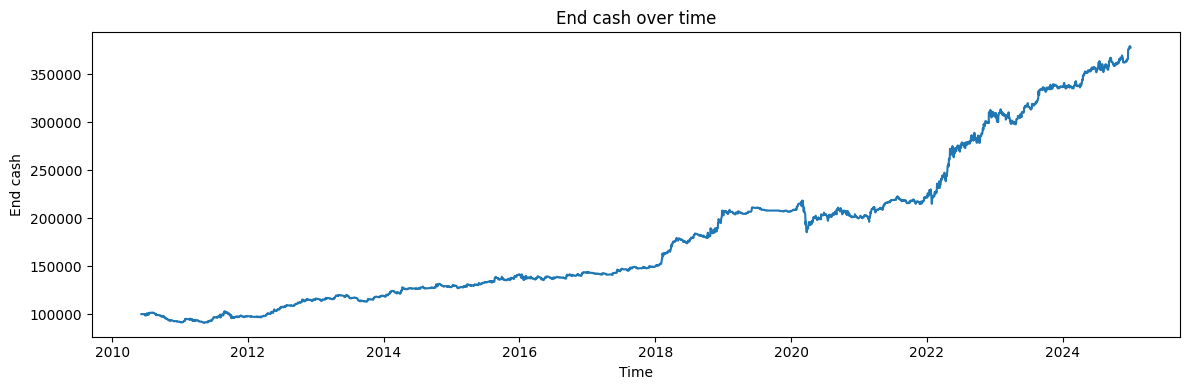

In [12]:
s = results_NASDAQ.copy()

# sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
# sp_df['SP500'] = 189095.59434874536 * sp_df['SP500'] / 1938.76
# sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

# if "observation_date" in sp_df.columns:
#     sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
#     sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
# plt.plot(sp_df['SP500'].astype(float))
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()

# Both product at the same time

In [13]:
results_NASDAQ

,date,start_cash,end_cash,pnl,return,traded
0,2010-06-07 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
1,2010-06-08 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
2,2010-06-09 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
3,2010-06-10 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
4,2010-06-11 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
...,...,...,...,...,...,...
3738,2024-12-24 00:00:00-05:00,375872.516755,378089.918236,2217.401481,0.005899,True
3739,2024-12-26 00:00:00-05:00,378089.918236,378089.918236,0.000000,0.000000,False
3740,2024-12-27 00:00:00-05:00,378089.918236,379093.073425,1003.155189,0.002653,True
3741,2024-12-30 00:00:00-05:00,379093.073425,378720.321267,-372.752158,-0.000983,True


In [14]:
results_SP

,date,start_cash,end_cash,pnl,return,traded
0,2010-06-07 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
1,2010-06-08 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
2,2010-06-09 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
3,2010-06-10 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
4,2010-06-11 00:00:00-04:00,100000.000000,100000.000000,0.000000,0.000000,False
...,...,...,...,...,...,...
3738,2024-12-24 00:00:00-05:00,205070.078476,205705.547431,635.468955,0.003099,True
3739,2024-12-26 00:00:00-05:00,205705.547431,205705.547431,0.000000,0.000000,False
3740,2024-12-27 00:00:00-05:00,205705.547431,204274.634844,-1430.912588,-0.006956,True
3741,2024-12-30 00:00:00-05:00,204274.634844,204274.634844,0.000000,0.000000,False


In [18]:
final_results = pd.DataFrame()
final_results['date'] = results_SP['date']
final_results['start_cash'] = 0.3 * results_SP['start_cash'] + 0.7 * results_NASDAQ['start_cash']
final_results['end_cash'] = 0.3 * results_SP['end_cash'] + 0.7 * results_NASDAQ['end_cash']
final_results

,date,start_cash,end_cash
0,2010-06-07 00:00:00-04:00,100000.000000,100000.000000
1,2010-06-08 00:00:00-04:00,100000.000000,100000.000000
2,2010-06-09 00:00:00-04:00,100000.000000,100000.000000
3,2010-06-10 00:00:00-04:00,100000.000000,100000.000000
4,2010-06-11 00:00:00-04:00,100000.000000,100000.000000
...,...,...,...
3738,2024-12-24 00:00:00-05:00,324631.785271,326374.606995
3739,2024-12-26 00:00:00-05:00,326374.606995,326374.606995
3740,2024-12-27 00:00:00-05:00,326374.606995,326647.541851
3741,2024-12-30 00:00:00-05:00,326647.541851,326386.615340


In [19]:
def _infer_periods_per_year(dates: pd.Series) -> float:
    """Infer periods/year from timestamp spacing (robust to missing days)."""
    d = pd.to_datetime(dates).sort_values().diff().dropna()
    if len(d) == 0:
        return 252.0  # fallback
    med_days = d.median() / pd.Timedelta(days=1)
    if med_days <= 1.5:   # roughly daily/business daily
        return 252.0
    if 5 <= med_days <= 9:  # roughly weekly
        return 52.0
    if 20 <= med_days <= 40:  # roughly monthly
        return 12.0
    # generic fallback
    return float(365.25 / med_days)

def evaluate_strategy(perf: pd.DataFrame, risk_free_rate: float = 0.0) -> dict:
    """
    Accepts a DataFrame with at least ['date','start_cash','end_cash'] and
    auto-creates: 'return' (periodic equity returns), 'pnl', 'traded' if missing.
    Returns Sharpe (annualized) and other metrics.
    """
    # Basic checks and ordering
    needed_min = {'date','start_cash','end_cash'}
    missing_min = needed_min.difference(perf.columns)
    if missing_min:
        raise ValueError(f"Missing required columns: {sorted(missing_min)}")

    df = perf.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # ----- Create missing columns -----
    # Periodic returns from equity curve (end_cash)
    if 'return' not in df.columns:
        # Period-to-period % change on end_cash; first period has no prior -> NaN
        df['return'] = df['end_cash'].pct_change()

    # PnL per row: prefer direct end - start if both present
    if 'pnl' not in df.columns:
        df['pnl'] = df['end_cash'] - df['start_cash']

    # Traded flag: True when there was any change in equity that period
    if 'traded' not in df.columns:
        df['traded'] = (df['pnl'].fillna(0) != 0) | (df['return'].fillna(0) != 0)

    # Clean returns (drop the first NaN produced by pct_change)
    daily_returns = pd.to_numeric(df["return"], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    n_obs = len(daily_returns)

    # Annualization base inferred from date spacing
    periods_per_year = _infer_periods_per_year(df['date'])

    # Total return (equity curve start->end)
    total_return = df["end_cash"].iloc[-1] / df["start_cash"].iloc[0] - 1

    # IRR (geometric mean) on observed periods
    if n_obs > 0:
        gross = (1.0 + daily_returns.values)
        irr_per_period = np.prod(gross) ** (1.0 / n_obs) - 1.0
        irr_annual = (1.0 + irr_per_period) ** periods_per_year - 1.0
    else:
        irr_per_period = np.nan
        irr_annual = np.nan

    # Volatility (annualized)
    if n_obs > 1:
        vol_per_period = float(daily_returns.std(ddof=1))
        vol_annual = vol_per_period * np.sqrt(periods_per_year)
    else:
        vol_per_period = np.nan
        vol_annual = np.nan

    # Sharpe (annualized): convert annual rf to per-period rf first
    rf_per_period = (1.0 + float(risk_free_rate)) ** (1.0 / periods_per_year) - 1.0
    if n_obs > 1 and pd.notna(vol_per_period) and vol_per_period > 0:
        sharpe = ((daily_returns.mean() - rf_per_period) / vol_per_period) * np.sqrt(periods_per_year)
    else:
        sharpe = np.nan

    # Hit ratio among traded periods
    traded_days = df[df["traded"] == True]
    if len(traded_days) > 0:
        hit_ratio = float((traded_days["pnl"] > 0).mean())
    else:
        hit_ratio = np.nan

    # Max drawdown on end_cash equity curve
    cum_curve = pd.to_numeric(df["end_cash"], errors="coerce")
    rolling_max = cum_curve.cummax()
    drawdowns = (cum_curve - rolling_max) / rolling_max
    mdd = float(drawdowns.min()) if len(drawdowns) else np.nan  # negative number

    return {
        "total_return": float(total_return),
        "irr_annual": float(irr_annual) if pd.notna(irr_annual) else np.nan,
        "vol_annual": float(vol_annual) if pd.notna(vol_annual) else np.nan,
        "sharpe": float(sharpe) if pd.notna(sharpe) else np.nan,
        "hit_ratio": float(hit_ratio) if pd.notna(hit_ratio) else np.nan,
        "mdd": mdd if pd.notna(mdd) else np.nan,
        "n_days": int(len(df)),
        "n_traded_days": int(len(traded_days)),
        "periods_per_year": float(periods_per_year),
    }

metrics = evaluate_strategy(final_results, risk_free_rate=0.0)  # 3% annual rf, for example
print(metrics["sharpe"])
metrics

1.1568377833703818


{'total_return': 2.2536795111323618,
 'irr_annual': 0.08269266813016363,
 'vol_annual': 0.07084923657050783,
 'sharpe': 1.1568377833703818,
 'hit_ratio': 0.41096455070074195,
 'mdd': -0.12082231134602235,
 'n_days': 3743,
 'n_traded_days': 2426,
 'periods_per_year': 252.0}

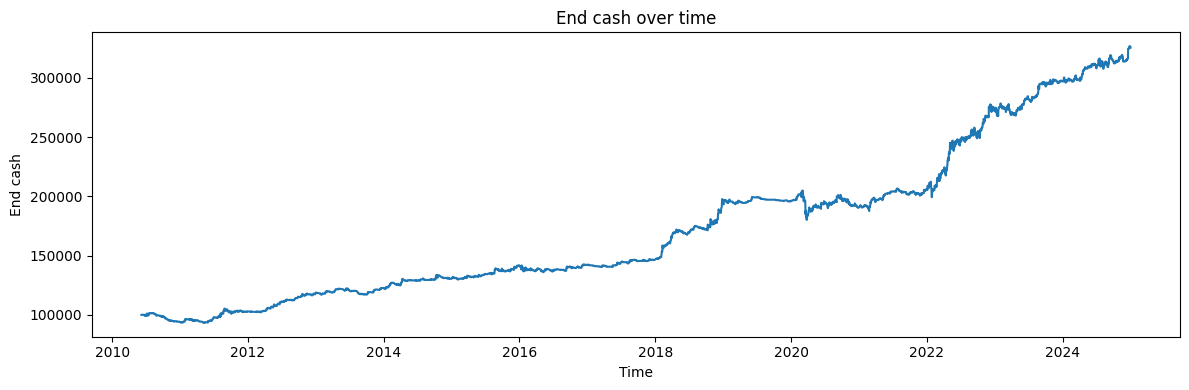

In [20]:
s = final_results.copy()

# sp_df = pd.read_csv("/data/workspace_files/SP500.csv")
# sp_df['SP500'] = 189095.59434874536 * sp_df['SP500'] / 1938.76
# sp_df

# If you have a Time column, make it the datetime index
if "Time" in s.columns:
    s["Time"] = pd.to_datetime(s["Time"], errors="coerce")
    s = s.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

# if "observation_date" in sp_df.columns:
#     sp_df["observation_date"] = pd.to_datetime(sp_df["observation_date"], errors="coerce")
#     sp_df = sp_df.dropna(subset=["observation_date"]).sort_values("observation_date").set_index("observation_date")

# Plot end_cash over time
plt.figure(figsize=(12,4))
plt.plot(s.date, s["end_cash"].astype(float))
# plt.plot(sp_df['SP500'].astype(float))
plt.title("End cash over time")
plt.xlabel("Time")
plt.ylabel("End cash")
plt.tight_layout()
plt.show()